In [1]:
"""

Jia Jinbu. 2020.09.15

Run by R version 3.5+

Nature Plants:
Post-transcriptional splicing of nascent RNA contributes to widespread intron retention in plants
https://www.nature.com/articles/s41477-020-0688-1

"""

In [37]:
suppressMessages({
    library(tidyverse)
    library(RColorBrewer)
    library(ggthemes)
    library(gridExtra)
    library(codetools)     
    library(ComplexHeatmap)                  
    select <- dplyr::select
    options("scipen"=100, "digits"=4)
})

# 0. read data

In [156]:
in_dir = "/path/to/data/"
lib_dir = "/path/to/genome/library/"
plot_dir = "/path/for/plot/"

In [437]:
#the file generated by `merge_read_info.R` or `merge_read_info_pacbio.R`
file_cb1 = paste0(in_dir, "test_sample1.read_info.detail.txt")
file_cb2 = paste0(in_dir, "test_sample2.read_info.detail.txt")
file_pacbio = paste0(in_dir, "test_PacBio.read_info.detail.txt")
#the file generated by prepare_data_for_splice_kinetics.py
file_cb1_rel_pos = paste0(in_dir, "test_sample1.intron_rel_pos.txt")
file_cb2_rel_pos = paste0(in_dir, "test_sample2.intron_rel_pos.txt")
file_pacbio_rel_pos = paste0(in_dir, "test_PacBio.intron_rel_pos.txt")
#the incompletely spliced ratio of polyA transcripts in Nanopore data
file_cb1_incompletely = paste0(in_dir, "test_sample1.rna_unspliced_ratio.txt")
file_cb2_incompletely = paste0(in_dir, "test_sample2.rna_unspliced_ratio.txt")
#the intron retention ratio of each intron in Nanopore data
file_cb1_ir = paste0(in_dir, "test_sample1.intron_unspliced_ratio.txt")
file_cb2_ir = paste0(in_dir, "test_sample2.intron_unspliced_ratio.txt")
#the intron retention ratio of each intron in Illumina RNA-seq
file_ngs_ir = paste0(in_dir, "test_ngs.iration.txt")
#the fpkm value of each gene in Illumina RNA-seq
file_ngs_fpkm = paste0(in_dir, "test_ngs.fpkm.txt")
#the information of ir identified in public RNA-seq data
file_ir_mutant <- paste0(in_dir, "test_public_ir_mutant.txt")
file_ir_treatment <- paste0(in_dir, "test_public_ir_treatment.txt")
#ir information of specific mutants or treatments
file_skip_ir <- paste0(in_dir, "test_skip.txt")
file_prmt5_ir <- paste0(in_dir, "test_prmt5.txt")
file_upf1upf3_ir <- paste0(in_dir, "test_upf1upf3.txt")
file_cold_ir <- paste0(in_dir, "test_cold.txt")
file_heat1_ir <- paste0(in_dir, "test_heat1.txt")
file_heat2_ir <- paste0(in_dir, "test_heat2.txt")

In [158]:
#mRNAs with constitutively spliced intron and constitutively spliced introns
file_select_mRNA = paste0(lib_dir, "mRNA_with_constitutively_spliced_intron.txt")
file_select_intron = paste0(lib_dir, "select_introns.txt")

In [6]:
#read full-length read information
suppressMessages({
    cb1 <- read_tsv(file_cb1, na="NA") 
    cb2 <- read_tsv(file_cb2, na="NA") 
    cb3 <- read_tsv(file_pacbio, na="NA") 
    cb1$sample <- "CB1"
    cb2$sample <- "CB2"
    cb3$sample <- "PacBio"
    cb <- bind_rows(cb1, cb2)
})

In [11]:
#read intron status and Pol II position
suppressMessages({
    cb1_rel_pos <- read_tsv(file_cb1_rel_pos)
    cb2_rel_pos <- read_tsv(file_cb2_rel_pos)
    cb3_rel_pos <- read_tsv(file_pacbio_rel_pos)
    cb1_rel_pos$sample <- "CB1"
    cb2_rel_pos$sample <- "CB2"
    cb3_rel_pos$sample <- "PacBio"
})

In [174]:
#read constitutively spliced introns and mRNAs with constitutively spliced intron
suppressMessages({
    select_mRNAs <- read_tsv(file_select_mRNA, col_names = F)$X1
    select_introns <- read_tsv(file_select_intron, col_names = F)$X1
})

In [176]:
#generate data
split_retention_introns <- function(d){
    #d is retention_introns (the column in cb)
    #the value in retention_introns not conating retained introns is "" or NA, never should be 0
    #the value in retention_introns_list not containg retained introns is NA, not emptly list
    return(sapply(str_split(d, ":"), as.numeric))
}

elongating <- cb %>% filter(type=="elongating",
                            mRNA %in% select_mRNAs)
pacbio_elongating <- cb3 %>% filter(type=="elongating",
                            mRNA %in% select_mRNAs)
polyA <- cb %>% filter(type=="polya",
                       mRNA %in% select_mRNAs)

elongating$retention_introns_list <- split_retention_introns(elongating$retention_introns)
polyA$retention_introns_list <- split_retention_introns(polyA$retention_introns)

In [398]:
#read Nanopore Incmpletely spliced ratio of polyA RNAs
add_label <- function(d, label){
    raw_names <- colnames(d)
    new_names <- c(raw_names[1], paste0(raw_names[2:length(raw_names)], "_", label))
    return(new_names)
}

suppressMessages({
    cb1_incompletely <- read_tsv(file_cb1_incompletely)
    cb2_incompletely <- read_tsv(file_cb2_incompletely)
    
    colnames(cb1_incompletely) <- add_label(cb1_incompletely, "CB1")
    colnames(cb2_incompletely) <- add_label(cb2_incompletely, "CB2")
    cb_incompletely <- full_join(cb1_incompletely, cb2_incompletely, by="mRNA")
    cb_incompletely[is.na(cb_incompletely)] <- 0
    cb_incompletely <- mutate(cb_incompletely, 
                    total_read_num_CB = total_read_num_CB1 + total_read_num_CB2,
                    ir_read_num_CB = ir_read_num_CB1 + ir_read_num_CB2,
                    ir_ratio_CB = ir_read_num_CB/total_read_num_CB)
})

In [340]:
#read full-length intron retention data
suppressMessages({
    cb1_ir <- read_tsv(file_cb1_ir)
    cb2_ir <- read_tsv(file_cb2_ir)
        
    colnames(cb1_ir) <- add_label(cb1_ir, "CB1")
    colnames(cb2_ir) <- add_label(cb2_ir, "CB2")
    
    cb_ir <- full_join(cb1_ir, cb2_ir, by="intron_id")
    cb_ir[is.na(cb_ir)] <- 0
    cb_ir <- mutate(cb_ir, 
                    total_read_num_CB = total_read_num_CB1 + total_read_num_CB2,
                    ir_read_num_CB = ir_read_num_CB1 + ir_read_num_CB2,
                    ir_ratio_CB = ir_read_num_CB/total_read_num_CB)
    
    cb_ir <- cb_ir %>% filter(intron_id %in% select_introns)
})

In [312]:
#read Illumina Intron retention data
suppressMessages({
    ngs_ir <- read_tsv(file_ngs_ir, na="NA")
    ngs_ir <- ngs_ir %>% filter(intron_id %in% select_introns)
    ngs_cb <- filter(ngs_ir, CB1_t >= 10, CB2_t >= 10, CB3_t >= 10)
    pts_introns <- ngs_cb$intron_id[ngs_cb$CB_iratio>=0.1]
})

In [423]:
#read fpkm
suppressMessages({
    ngs_fpkm <- read_tsv(file_ngs_fpkm)
    ngs_fpkm <- ngs_fpkm %>% mutate(CB = (CB1+CB2+CB3)/3,
                       Cyto = (Cyto1+Cyto2+Cyto3)/3,
                       NP = (NP1+NP2+NP3)/3)
})

In [429]:
#read public ir
suppressMessages(
{
    ir_mutant <- read_tsv(file_ir_mutant)
    ir_mutant$IR_up_pintron_ratio <- ir_mutant$IR_up_pintron/ir_mutant$IR_up
    ir_mutant$IR_up_pintron_ratio[ir_mutant$IR_up==0] <- 0
    ir_mutant$label <- paste0(ir_mutant$group_name, " ", ir_mutant$mutant)
    
    ir_treatment <- read_tsv(file_ir_treatment)
    ir_treatment$IR_up_pintron_ratio <- ir_treatment$IR_up_pintron/ir_treatment$IR_up
    ir_treatment$IR_up_pintron_ratio[ir_treatment$IR_up==0] <- 0
    ir_treatment$label <- paste0(ir_treatment$group_name, " ", ir_treatment$treatment)

    ir_treatment$col_label <- factor(ir_treatment$col_label, levels=c(2,1,3,0),
                                  labels=c("cold", "heat", "flg22", "other" ))
    
})

# 1. Figure 1
Nature Plants:

Post-transcriptional splicing of nascent RNA contributes to widespread intron retention in plants

https://www.nature.com/articles/s41477-020-0688-1

## 1.1 The fold change in 3′-end enrichment around the 5′ splice site (5′ SS) and 3′ splice site (3′ SS) of introns.

In [47]:
stat_read_3end_exon_intron <- function(data, stat_length=30){
  #     exon                               intron                   exon
  #++++++++++++++++++++++++++----------------------------------+++++++++++++++++++++
  #                  right_d|left_d                     right_d|left_d          
  #input: read_info
  #remove genes without intron
  #left is from 5' to 3', 1 to 30. right is form 3' to 5', 0 to -29
  d <- data %>% 
    mutate(left = l_feature_length + l_pos3,
           right = l_pos3) %>% 
    select(mRNA, mRNA_intron_num, l_feature_type, l_feature_num, left, right)
  #remove the first exon, and the genes without intron
  left_d <- d %>% 
    filter(!((l_feature_type=="exon") & (l_feature_num == 1)), left <= stat_length) %>%
    mutate(pos = ifelse(l_feature_type=="exon", left + stat_length * 3, left+stat_length))
  #remove the last exon, and the genes without intron
  right_d <- d %>% 
    filter(!((l_feature_type=="exon") & (l_feature_num == mRNA_intron_num + 1)), right > -stat_length) %>%
    mutate(pos = ifelse(l_feature_type=="exon", right + stat_length, right + stat_length*3))
  x <- table(c(left_d$pos, right_d$pos))
  
  fill_x <- function(x){
    x1 <- rep(0, stat_length*4)
    x_names <- as.numeric(names(x))
    for (i in 1:length(x)){
      x1[x_names[i]] <- x[i]
    }
    return(x1)
  }
  x <- fill_x(x)
  x <- matrix(x, ncol=4)
  #x <- x / median(x)
  colnames(x) <- c("exon 3'", "intron 5'", "intron 3'", "exon 5'")
  rownames(x) <- 1:stat_length
  return(x)
}

In [40]:
cal_mapping_adapter_distance <- function(data){
  #the distance between genome mapping region and the 3' adapter mappign region in read
  a <- (data$r_align_start - data$r_primer_start) - data$genome_align_end
  b <- data$genome_align_start - (data$f_align_end + data$f_primer_start)
  c <- data$rna_strand==data$read_strand
  v <- b
  v[c] <- a[c]
  return(v)
}

In [95]:
tmp_change_d <- function(d){
  d1 <- tibble(pos=rep(-29:30, 2), 
         n=c(d[,1], d[,2], d[,3], d[,4]),
         type=rep(c("5'", "3'"), each=60))
  d1$type <- factor(d1$type, levels=c("5'", "3'"))
  return(d1)
}

tmp_plot_func <- function(d, end3=TRUE, max_y=520, for_pdf=FALSE){
    if (end3){
        ylab <- "3' End Enrichment Fold"
    } else {
        ylab <- "5' End Enrichment Fold"
    }
    p <- ggplot(d, aes(pos, n)) + 
      geom_bar(stat="identity", col="#377EB8", fill="#377EB880",size=0.2) +   #col="#FC4E07", fill="#FC4E0750"
      facet_wrap(~type) + 
      ylab(ylab) + 
      xlab("") +
      scale_y_continuous(expand = c(0, 0), limits=c(0,max_y)) + 
      scale_x_continuous(expand = c(0.04, 0), limits=c(-29.5, 30.5), breaks=c(-25, 0, 25)) + 
      theme_tufte()
    
    if (for_pdf){
        p <- p + theme(legend.position = "none",
            panel.spacing = unit(1, "lines"),
            axis.line.y = element_line(color="black", size = 0.2),
            text=element_text(size=6, family=""), #face="bold",
            #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
            axis.text.x = element_text(size=6, color="black"))
    } else {
        p <- p + theme(legend.position = "none",
            panel.spacing = unit(1, "lines"),
            axis.line.y = element_line(color="black", size = 0.2),
            text=element_text(size=10, family=""), #face="bold",
            #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
            axis.text.x = element_text(size=10, color="black"))
    }
    return(p)
}

In [41]:
tmp_genome_adapter_distance <- cal_mapping_adapter_distance(cb)

In [55]:
d <- cb %>% filter(type %in% c("elongating", "splicing_intermediate"),
              mRNA_intron_num > 0,
              tmp_genome_adapter_distance == 0)

In [56]:
end3_dis_stat <- stat_read_3end_exon_intron(d, 30)
end3_dis_stat_median <- end3_dis_stat/(median(end3_dis_stat))
end3_dis_stat_for_ggplot <- tmp_change_d(end3_dis_stat_median)

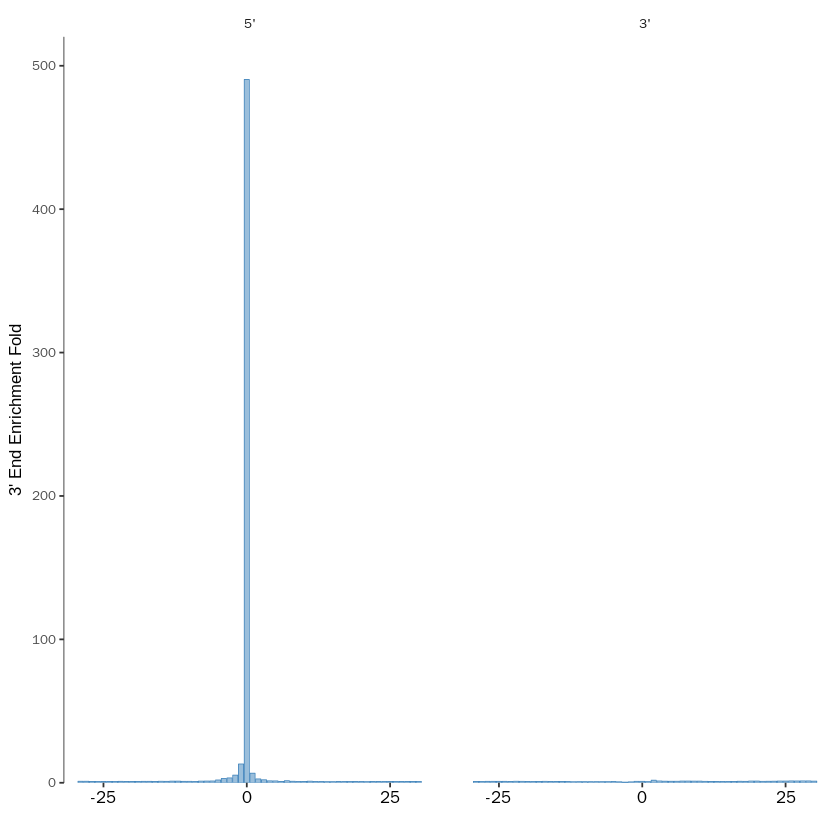

In [96]:
tmp_fileout_pdf <- paste0(plot_dir, "end_3_pos.pdf")
pdf(tmp_fileout_pdf, 2.25, 1.8)
p <- tmp_plot_func(end3_dis_stat_for_ggplot, for_pdf=T)
print(p)
dev.off()

p <- tmp_plot_func(end3_dis_stat_for_ggplot, for_pdf=F)
print(p)

In [99]:
remove(d)

## 1.2 The distribution of Nanopore full-length clean read counts per gene

In [101]:
#total number of coding genes in Arabidopsis
total_coding_gene_num <- 27655

In [ ]:
d <- bind_rows(cb1 %>% filter(end_polyA_type %in% c(1,3),
                             nf,
                             end5ss_type==0),
               cb1 %>% filter(end_polyA_type == 7),
               cb2 %>% filter(end_polyA_type %in% c(1,3),
                             nf,
                             end5ss_type==0),
               cb2 %>% filter(end_polyA_type == 7))


In [ ]:
(cb %>% filter(type %in% ))$mRNA

In [111]:
d <- table(cb$mRNA[cb$type %in% c("elongating", "polya")])

In [112]:
d <- tibble(n=c(d, rep(0, total_coding_gene_num - length(d))))

In [114]:
d$count_log <- log2(d$n+1)

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


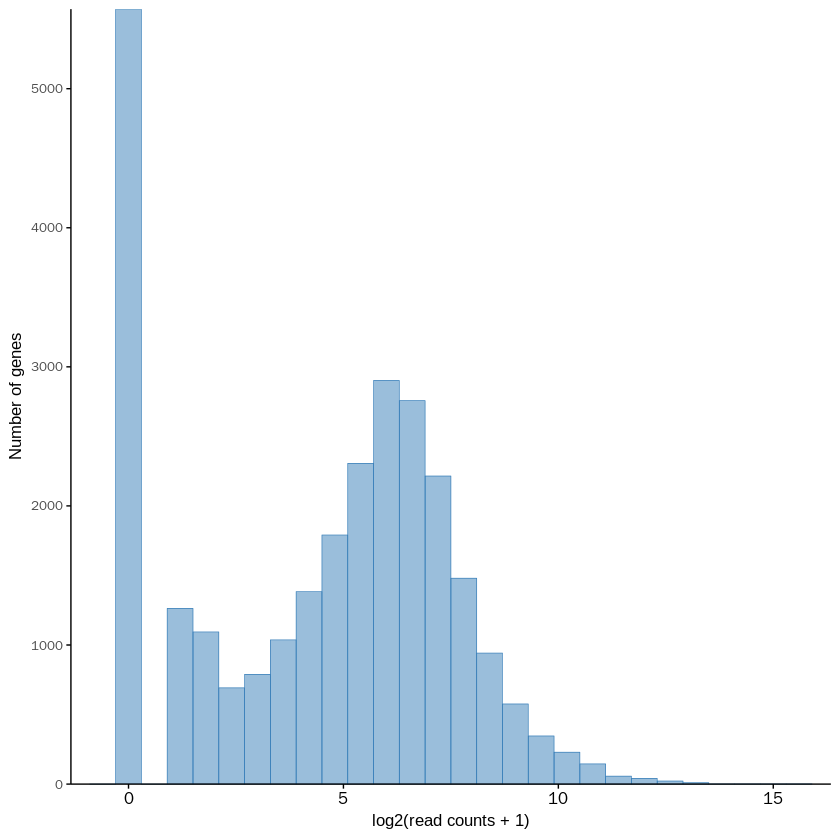

In [143]:
tmp_plot <- function(d, for_pdf=TRUE){
    
    p <- ggplot(d, aes(x=count_log)) + 
          geom_histogram(binwidth=0.6, col="#377EB8", fill="#377EB880",size=0.2) +
          scale_y_continuous(expand = c(0, 0)) +  #, limits=c(0,3200)
          scale_x_continuous(expand = c(0.02, 0), limits=c(-1,16)) + 
          xlab("log2(read counts + 1)") + 
          ylab("Number of genes") +
          theme_classic()
    if (for_pdf) {
        p <- p + theme(text=element_text(size=6),
                axis.line = element_line(color="black", size = 0.2),
                axis.ticks = element_line(colour = "black", size = 0.2),
                axis.text.x = element_text(size=6, color="black"))
    } else {
        p <- p + theme(text=element_text(size=10),
                axis.line = element_line(color="black", size = 0.4),
                axis.ticks = element_line(colour = "black", size = 0.4),
                axis.text.x = element_text(size=10, color="black"))
    }
          
}

tmp_fileout_pdf <- paste0(plot_dir, "gene.read_count.distribution.pdf")
pdf(tmp_fileout_pdf, 2.25, 1.6)
p <- tmp_plot(d, for_pdf=TRUE)
print(p)
dev.off()

print(tmp_plot(d, for_pdf=FALSE))

# 2. Figure2

## 2.1 All unspliced, partially spliced and fully spliced fractions in the elongating and polyadenylated transcripts on chromatin.

In [237]:
cal_spliced_type <- function(data){
    spliced_type <- rep("Partially spliced", nrow(data))
    spliced_type[data$retention_intron_num == data$span_intron_num] <- "All unspliced"
    spliced_type[data$retention_intron_num == 0] <- "All spliced"
    spliced_type <- factor(spliced_type, 
                            levels=c("All unspliced", "Partially spliced",  "All spliced"))
    return(spliced_type)
}

In [238]:
elongating$spliced_type <- cal_spliced_type(elongating)
polyA$spliced_type <- cal_spliced_type(polyA)

In [243]:
d <- bind_rows(elongating %>% filter(span_intron_num>0) %>%
                   group_by(sample, spliced_type) %>% 
                   summarise(count=n(), rna_type="elongating"),
               polyA %>% 
                   group_by(sample, spliced_type) %>% 
                   summarise(count=n(), rna_type="polyA"))
d$rna_type <- factor(d$rna_type, levels=c("elongating", "polyA"))
d <- d %>% group_by(sample, rna_type) %>% 
            mutate(ratio=count/sum(count))

In [233]:
tmp_plot <- function(d, for_pdf=TRUE){
    p <- ggplot(d, aes(rna_type, ratio, fill=spliced_type)) + 
              geom_bar(stat="identity") + 
              facet_wrap(~sample) + 
              scale_y_continuous(expand = c(0, 0), limits=c(0,1), labels=scales::percent) + 
              #scale_x_continuous(expand = c(0.04, 0), limits=c(-29, 30), breaks=c(-25, 0, 25)) + 
              xlab("") + 
              ylab("Percentage of reads") + 
              labs(fill = "") + #Spliced\nStatus
              theme_tufte() 
    if (for_pdf){
        p <- p + theme(text=element_text(size=6, family=""),
                legend.key.size = unit(0.7,"line"),
                legend.title=element_blank(),
                legend.text = element_text(size=8),
                axis.line.y = element_line(color="black", size = 0.2),
                axis.ticks = element_line(colour = "black", size = 0.2),
                #legend.margin=margin(0,0,0,0),
                #legend.box.margin=margin(-10,0,-10,-10),
                panel.spacing = unit(0.3, "lines"),
                #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                axis.text.x = element_text(angle = 270, vjust=0.5, hjust=0, size=6, color="black"),
                strip.text.x = element_text(margin = margin(1,0,1,0)))
    } else {
        p <- p + theme(text=element_text(size=10, family=""),
                legend.key.size = unit(1,"line"),
                legend.title=element_blank(),
                legend.text = element_text(size=12),
                axis.line.y = element_line(color="black", size = 0.4),
                axis.ticks = element_line(colour = "black", size = 0.4),
                #legend.margin=margin(0,0,0,0),
                #legend.box.margin=margin(-10,0,-10,-10),
                panel.spacing = unit(0.3, "lines"),
                #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                axis.text.x = element_text(angle = 270, vjust=0.5, hjust=0, size=10, color="black"),
                strip.text.x = element_text(margin = margin(1,0,1,0)))
    }

    return(p)
}

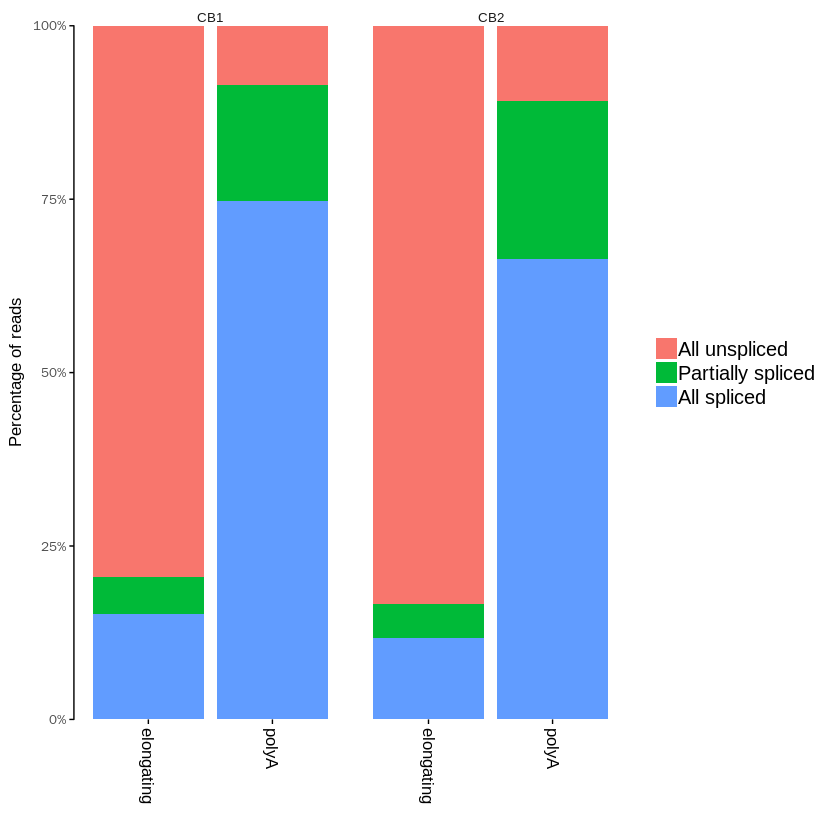

In [234]:
tmp_fileout_pdf <- paste0(plot_dir, "unspliced_ratio.barplot.pdf")
pdf(tmp_fileout_pdf, 2.4, 2)
p <- tmp_plot(d, for_pdf=TRUE)
print(p)
dev.off()

p <- tmp_plot(d, for_pdf=FALSE)
print(p)

## 2.2 Global analysis of the ratio of spliced introns versus the transcription distance from the 3′ splice site.

In [267]:
stat_intron_splice <- function(data, bin_length = 20){
  to_bin <- function(x, l=20){
    (x - 1) %/% l * l + (1 + l)/2
  }
  spliced_stat <- data %>%
    group_by(rel_pos) %>% 
    summarise(unspliced=sum(retention), total=n()) 
  if (bin_length == 1){
    spliced_stat$pos_bin <- spliced_stat$rel_pos
  } else{
    spliced_stat$pos_bin <- to_bin(spliced_stat$rel_pos, bin_length)
  }
  spliced_stat <- spliced_stat %>%
    mutate(spliced_ratio = 1 - unspliced/total) %>%
    group_by(pos_bin) %>%
    summarise(mean_spliced_ratio=mean(spliced_ratio),
              unspliced = sum(unspliced),
              total = sum(total),
              spliced = total - unspliced,
              sd=sd(spliced_ratio),
              spliced_ratio = spliced/total)
  return(spliced_stat)
}

plot_splicing_kinetics <- function(xs, legend.position=c(0.2, 0.9), xlim_max=3000, for_pdf=TRUE){

    if (for_pdf){
        p <- ggplot(xs, aes(x=pos_bin, y=spliced_ratio, col=sample)) + 
                geom_point(size=0.1, shape=16) +
                geom_line(size=0.2) +
                #geom_ribbon(aes(x=pos_bin, ymin=spliced_ratio-sd, ymax=spliced_ratio+sd,fill=sample), 
                #            colour = NA,
                #            alpha=0.3) +
                coord_cartesian(xlim=c(0,xlim_max), ylim=c(0,1)) + 
                scale_y_continuous(labels=scales::percent) +
                xlab("Distance from 3'SS (nt)") + 
                ylab("Percentage of spliced") +
                theme_classic() +
                theme(text=element_text(size=6),
                    legend.position = legend.position, 
                    legend.key.size = unit(0.7,"line"),
                    legend.title=element_blank(),
                    legend.text = element_text(size=6),
                    legend.margin=margin(0,0,0,0),
                    legend.box.margin=margin(-10,0,-10,-10),
                    axis.line.y = element_line(color="black", size = 0.2),
                    axis.line.x = element_line(color="black", size = 0.2),
                    axis.ticks = element_line(colour = "black", size = 0.2),
                    panel.margin = unit(0.1, "lines"),
                    #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                    axis.text.x = element_text(size=6, color="black")
                ) 
  } else {
        p <- ggplot(xs, aes(x=pos_bin, y=spliced_ratio, col=sample)) + 
                geom_point(size=1, shape=16) +
                geom_line(size=0.6) +
                #geom_ribbon(aes(x=pos_bin, ymin=spliced_ratio-sd, ymax=spliced_ratio+sd,fill=sample), 
                #            colour = NA,
                #            alpha=0.3) +
                coord_cartesian(xlim=c(0,xlim_max), ylim=c(0,1)) + 
                scale_y_continuous(labels=scales::percent) +
                xlab("Distance from 3'SS (nt)") + 
                ylab("Percentage of spliced") +
                theme_classic() +
                theme(text=element_text(size=10),
                    legend.position = legend.position, 
                    legend.key.size = unit(1,"line"),
                    legend.title=element_blank(),
                    legend.text = element_text(size=10),
                    legend.margin=margin(0,0,0,0),
                    legend.box.margin=margin(-10,0,-10,-10),
                    axis.line.y = element_line(color="black", size = 0.2),
                    axis.line.x = element_line(color="black", size = 0.2),
                    axis.ticks = element_line(colour = "black", size = 0.2),
                    panel.margin = unit(0.1, "lines"),
                    #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                    axis.text.x = element_text(size=10, color="black")
                ) 
  } 
  return(p)
}



In [249]:
xs1 <- stat_intron_splice(cb1_rel_pos %>% filter(read_core_id  %in% elongating$read_core_id))

In [251]:
xs2 <- stat_intron_splice(cb2_rel_pos %>% filter(read_core_id  %in% elongating$read_core_id))

In [259]:
xs3 <- stat_intron_splice(cb3_rel_pos %>% filter(read_core_id  %in% pacbio_elongating$read_core_id))

In [260]:
xs1$sample <- "CB1"
xs2$sample <- "CB2"
xs3$sample <- "PacBio"


In [261]:
xs <- bind_rows(xs1, xs2, xs3)


Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”


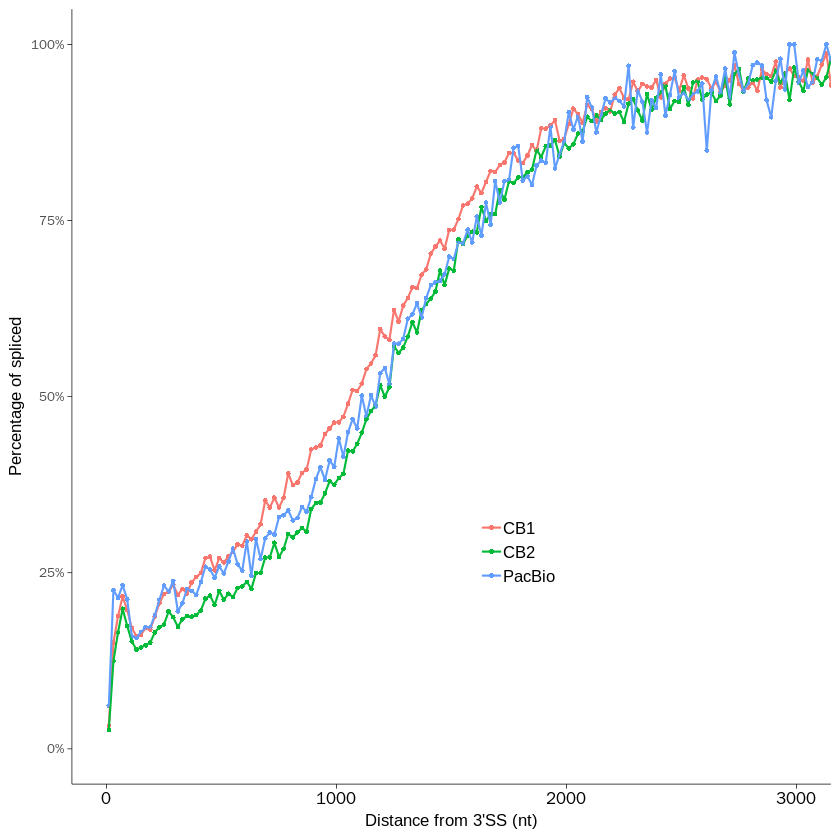

In [268]:
p <- plot_splicing_kinetics(xs, c(0.6, 0.3), for_pdf=FALSE)
print(p)

tmp_fileout_pdf <- paste0(plot_dir, "elongating.rel_pos.Nanopore.PacBio.spliced.pdf")
pdf(tmp_fileout_pdf , 1.8, 1.6)
p <- plot_splicing_kinetics(xs, c(0.6, 0.3))
print(p)
dev.off()

## 2.3 The frequency of different splicing orders in adjacent intron pairs with different splicing states.

In [284]:
#require span_intron_num，retention_introns_num
stat_which_first_splice <- function(data){
  
    cal_retention_intron_num <- function(data){
        a <- sapply(data$retention_introns_list, length)
        a[is.na(data$retention_introns_list)] <- 0
        return(a)
    }
    
    data$retention_introns_num <- cal_retention_intron_num(data)
    #select partically spliced introns
    d <- data %>% select(retention_introns_list, 
                       span_intron_num,
                       retention_introns_num) %>%
    filter(retention_introns_num!=0, retention_introns_num!=span_intron_num)

    up_first = 0
    down_first = 0  

    for (i in 1:nrow(d)){ 
    ir_list <- d$retention_introns_list[[i]]
    n <- d$span_intron_num[i]

    #ir_list should not be NA as has removed retention_introns_num ==0
    #l >= 1
    l <- length(ir_list) 
    #1. For the first unspliced intron.
    #If it is not the first intron,  indicate the upstream intron has been spliced
    if (ir_list[1] > 1){
        up_first = up_first + 1
    }
    #2. For the last unspliced intron.
    #If it is not the last introns having been transcripted, the downstream intron has been spliced
    if (ir_list[l] < n){
        down_first = down_first + 1
    }
    #3. For the middle unspliced intron.
    #if n gaps in ir_list, then both up_first and down_first add n
    #e.g. ir_list <- c(2, 6, 8)
    #two gap in ir_list: 1) 2,6 is not continous 2) 6,8 is not continous.
    #2-3  down-stream spliced firstly
    #5-6  up-stream spliced firstly
    #6-7  down-stream spliced firstly
    #7-8  up-stream spliced firstly
    if (l >= 2){
        tmp_x <- sum(ir_list[-1] - ir_list[-l] > 1)
        up_first = up_first + tmp_x
        down_first = down_first + tmp_x
    }
    }
    return(c(up_first, down_first))
}

In [285]:
d <- tibble( count = c(stat_which_first_splice(filter(elongating, sample=="CB1" )),
                       stat_which_first_splice(filter(elongating, sample=="CB2" ))),
             sample = c("CB1", "CB1", "CB2", "CB2"),
             type= c("up_first", "down_first", "up_first", "down_first"))
d <- d %>% group_by(sample) %>% mutate(iratio=count/sum(count))
d$type <- factor(d$type, levels=c("up_first", "down_first"))


Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”


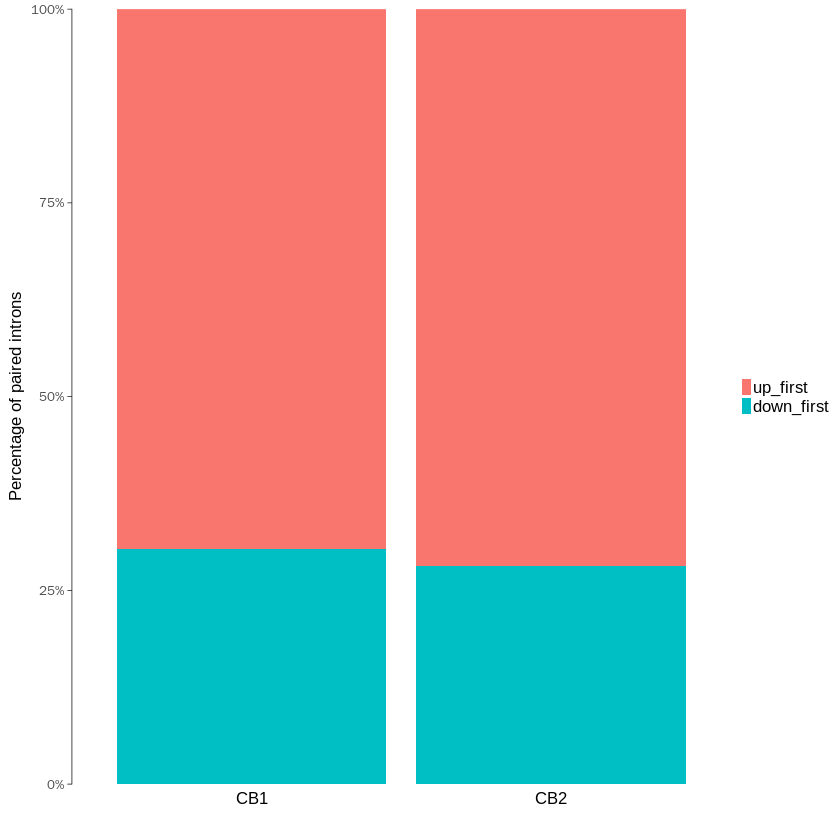

In [288]:
tmp_plot <- function(d, for_pdf=TRUE){
    if (for_pdf){
        p <- ggplot(d, aes(sample, iratio, fill=type)) +
              geom_bar(stat="identity") +  #, position="dodge"
              scale_y_continuous(expand = c(0, 0), limits=c(0,1), labels=scales::percent) + 
              #scale_x_continuous(expand = c(0.04, 0), limits=c(-29, 30), breaks=c(-25, 0, 25)) + 
              xlab("") + 
              ylab("Percentage of paired introns") + 
              labs(fill = "") + #Spliced\nStatus
              theme_tufte() +
              theme(text=element_text(size=6, family=""),
                    legend.key.size = unit(0.5,"line"),
                    legend.title=element_blank(),
                    legend.text = element_text(size=6),
                    axis.line.y = element_line(color="black", size = 0.2),
                    axis.ticks.y = element_line(colour = "black", size = 0.2),
                    axis.ticks.x = element_blank(), #element_line(colour = "black", size = 0.2),
                    legend.margin=margin(0,0,0,0),
                    legend.box.margin=margin(-5,0,-5,-5),
                    panel.margin = unit(0.3, "lines"),
                    #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                    axis.text.x = element_text(size=6, color="black"),
                    strip.text.x = element_text(margin = margin(1,0,1,0))
                    )
    } else {
        p <- ggplot(d, aes(sample, iratio, fill=type)) +
              geom_bar(stat="identity") +  #, position="dodge"
              scale_y_continuous(expand = c(0, 0), limits=c(0,1), labels=scales::percent) + 
              #scale_x_continuous(expand = c(0.04, 0), limits=c(-29, 30), breaks=c(-25, 0, 25)) + 
              xlab("") + 
              ylab("Percentage of paired introns") + 
              labs(fill = "") + #Spliced\nStatus
              theme_tufte() +
              theme(text=element_text(size=10, family=""),
                    legend.key.size = unit(0.5,"line"),
                    legend.title=element_blank(),
                    legend.text = element_text(size=10),
                    axis.line.y = element_line(color="black", size = 0.2),
                    axis.ticks.y = element_line(colour = "black", size = 0.2),
                    axis.ticks.x = element_blank(), #element_line(colour = "black", size = 0.2),
                    legend.margin=margin(0,0,0,0),
                    legend.box.margin=margin(-5,0,-5,-5),
                    panel.margin = unit(0.3, "lines"),
                    #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                    axis.text.x = element_text(size=10, color="black"),
                    strip.text.x = element_text(margin = margin(1,0,1,0))
                    )
    }
    return(p)
}
p <- tmp_plot(d, for_pdf=FALSE)
print(p)

tmp_fileout_pdf <- paste0(plot_dir, "pair_intron_splice_first.format.pdf")
pdf(tmp_fileout_pdf, 1.5, 1.6)
p <- tmp_plot(d, for_pdf=TRUE)
print(p)
dev.off()

## 2.4 Visualization of the splicing status of multi-introns in each nascent transcript derived from genes with five introns.

In [297]:
stat_splice_pattern <- function(s, n, space=0.1){ 
    #s: retention_introns string, seprated by :
    #n: span_intron_num
    #1. s containg NA/""/0, if is NA, `table` would not display in default
    #Convert all NA/""/0 to "0"
    s[is.na(s)] <- "0"
    s[s==""] <- "0"
    #2. table
    #  0  1:2:3  2:3   #name
    # 10    5     4    #count
    origin_d <- sort(table(s), decreasing=T)
    #3. convert the name of table result to list
    introns <- sapply(str_split(names(origin_d), ":"), as.numeric)
    #4. convert list to 0, 1
    #for a read spaning four introns，1:2:3 to c(1, 1, 1, 0)
    tmp_irlist_to_01 <- function(i){
      x <- c(rep(0, n))
      intron <- introns[[i]]
      #intron[1] != 0 not all spliced
      if (intron[1] != 0){
        for (j in intron){
          x[j] = 1
        }
      }
      return(x)
    }
    #for sapply，the first element -> the first column, not the first row, thus use `t`
    d <- sapply(1:length(origin_d), tmp_irlist_to_01)
    if (n == 1){
      d <- as_tibble(d)
    } else {
      d <- as_tibble(t(d))
    }
    colnames(d) <- c(1:n)
    d$count <- c(origin_d)

    total_num <- sum(d$count)

    #5. sorted by ir status, determine the dispaly order
    #All spliced, in order, not in order, All unspliced.
    #Note `order` is a function, never set a new variable with a name `order` to overlap it
    tmp_order <- stat_not_in_order_intron_num_add3(introns, n)
    d$order <- 1     #1 All spliced
    d$order[tmp_order == 3] <- 2  #3 in order
    d$order[tmp_order > 3] <- 3 #>3 not in order
    d$order[tmp_order == 2] <- 4 #2 All unspliced
    #order by `order` first, and then order by the ir status
    d <- d[do.call(order, d[,c(n+2, 1:n)]),]
    d$span_intron_num <- n
    return(d)
}


generate_for_splice_pattern <- function(d_list, part_space=1, little_space=0.1, 
                                        xlim_min=0.1, xlim_max_adjust=0.1, for_pdf=TRUE){
    #The value of any part should not be empty
    
    generate_single_part <- function(d, space=0.1){
        #Note d, wide to long. d is the data of a specific part

        n <- d$span_intron_num[1]
        total_num <- sum(d$count)
        #calculate height, min:0, max:sum(count)
        d$height <- cumsum(d$count)
        d$ymin <- total_num - d$height
        d$ymax <- total_num - c(0, d$height[-length(d$height)] )
        #wide to long based on the intron position.
        #x: based on the intron position (from 5' mRNA to 3' mRNA).
        #the first intron is `space` to `(1-space)`，0.1-0.9
        d <- gather(d, !!(1:n), key="x", value="Intron")
        d$x <- as.numeric(d$x)
        d$xmin <- d$x - 1 + space
        d$xmax <- d$x - space
        d$Intron <- factor(d$Intron, labels=c("spliced", "unspliced"))
        d$Intron <- factor(d$Intron, levels=c("unspliced", "spliced"))

        #convert y to a value between 0-1
        ymax <- max(d$ymax)
        d$ymin <- d$ymin / ymax
        d$ymax <- d$ymax / ymax
        return(d)
    }

    combine_multi_part <- function(d, space=1){
        #the list of data generated by `generate_single_part` and representting each part
        start_x <- 0
        x_breaks <- c()
        x_labels <- c()
        x_group_breaks <- c()
        for (i in 1:length(d)){
            #cal xmin and xmax
            tmp_d <- d[[i]]
            tmp_column_num <- max(tmp_d$x)
            if (i > 1){
              tmp_d$xmin <- tmp_d$xmin + start_x
              tmp_d$xmax <- tmp_d$xmax + start_x
              d[[i]] <- tmp_d
            }
            #the middle point of each intron bar
            x_breaks <- c(x_breaks, 1:tmp_column_num + start_x - 0.5)
            #the middle point of each part
            x_group_breaks <- c(x_group_breaks, mean(1:tmp_column_num + start_x - 0.5))
            #the label of each intron bar
            x_labels <- c(x_labels, 1:tmp_column_num)
            #cal and record the init x value
            start_x <- start_x + tmp_column_num + space
        }
        d <- do.call(bind_rows, d)
        return(list(d=d, x_breaks=x_breaks, x_labels=x_labels, x_group_breaks =x_group_breaks))
    } 

    d_list <- lapply(d_list, generate_single_part, space=little_space)
    d <- combine_multi_part(d_list, part_space)

    if (for_pdf){
        p <- ggplot(d$d) + 
        geom_rect(aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, fill=Intron, colour=Intron)) +
          scale_x_continuous(name="",breaks=d$x_breaks, labels=d$x_labels) + 
          scale_y_continuous(expand = c(0, 0), breaks=seq(0,1,0.1), labels=scales::percent_format(accuracy = 1)) +
          coord_cartesian(clip="off", ylim=c(0,1), xlim=c(xlim_min, max(d$d$xmax)+xlim_max_adjust)) + 
          theme_tufte() +
          ylab("Percentage of transcripts") +
          theme(text=element_text(size=6, family=""),
                axis.line.y = element_line(color="black", size = 0.2),
                axis.ticks = element_line(colour = "black", size = 0.2),
                legend.key.size = unit(0.5,"line"),
                legend.text = element_text(size=6),
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-10,0,-10,-10),
                panel.spacing = unit(0.1, "lines"),
                #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                axis.text.x = element_text(size=6, color="black")
                ) +
          geom_text(aes(x, y=-0.12, label=label), 
                    data.frame(x=d$x_group_breaks, label=c(paste0("S", 1:5), "polyA")),
                    size=6*5/14)
    } else {
        p <- ggplot(d$d) + 
        geom_rect(aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, fill=Intron, colour=Intron)) +
          scale_x_continuous(name="",breaks=d$x_breaks, labels=d$x_labels) + 
          scale_y_continuous(expand = c(0, 0), breaks=seq(0,1,0.1), labels=scales::percent_format(accuracy = 1)) +
          coord_cartesian(clip="off", ylim=c(0,1), xlim=c(xlim_min, max(d$d$xmax)+xlim_max_adjust)) + 
          theme_tufte() +
          ylab("Percentage of transcripts") +
          theme(text=element_text(size=10, family=""),
                axis.line.y = element_line(color="black", size = 0.2),
                axis.ticks = element_line(colour = "black", size = 0.2),
                legend.key.size = unit(1,"line"),
                legend.text = element_text(size=10),
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-10,0,-10,-10),
                panel.spacing = unit(0.1, "lines"),
                #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                axis.text.x = element_text(size=10, color="black")
                ) +
          geom_text(aes(x, y=-0.12, label=label), 
                    data.frame(x=d$x_group_breaks, label=c(paste0("S", 1:5), "polyA")),
                    size=6*5/14)
    }
    return(list(d, p))
}

In [ ]:
dd <- elongating %>% filter(mRNA_intron_num == 5, 
                            span_intron_num>0) 
dd1 <- stat_splice_pattern(dd$retention_introns[dd$span_intron_num == 1], 1)
dd2 <- stat_splice_pattern(dd$retention_introns[dd$span_intron_num == 2], 2)
dd3 <- stat_splice_pattern(dd$retention_introns[dd$span_intron_num == 3], 3)
dd4 <- stat_splice_pattern(dd$retention_introns[dd$span_intron_num == 4], 4)
dd5 <- stat_splice_pattern(dd$retention_introns[dd$span_intron_num == 5], 5)
dd6 <- stat_splice_pattern(polyA$retention_introns[polyA$mRNA_intron_num == 5], 5)

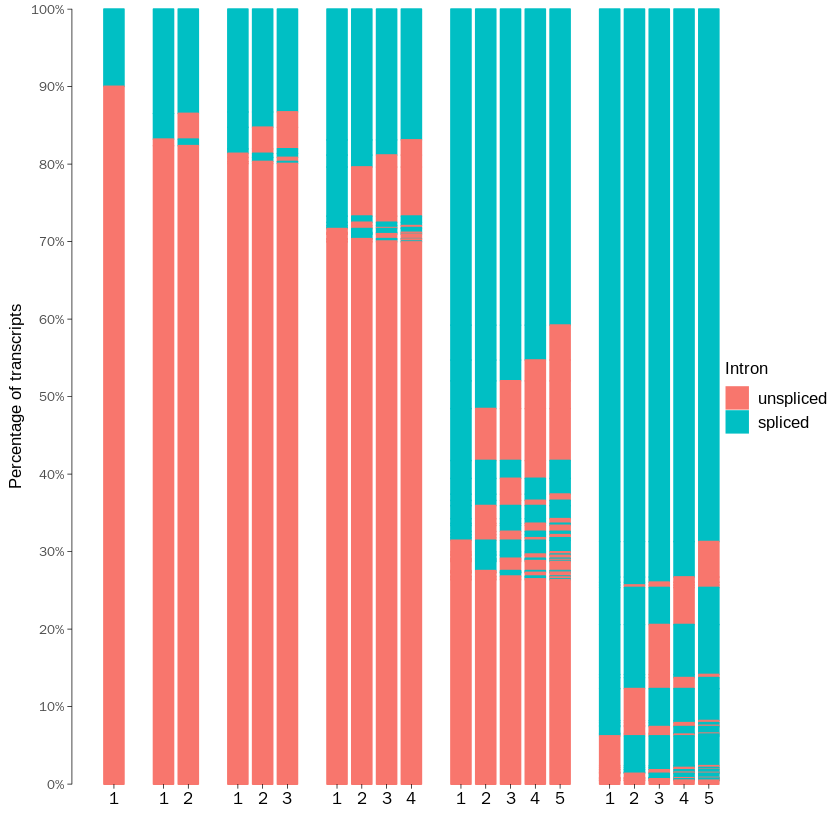

In [300]:
tmp_fileout_pdf <- paste0(plot_dir, "5intron_gene.spliced_process.heatmap.pdf")

pdf(tmp_fileout_pdf, 3.7,2)
dddd <- generate_for_splice_pattern(list(dd1, dd2, dd3, dd4, dd5, dd6), 1, 0.1, 0, -1, for_pdf=TRUE)
p <- dddd[[2]]
print(p)
dev.off()

dddd <- generate_for_splice_pattern(list(dd1, dd2, dd3, dd4, dd5, dd6), 1, 0.1, 0, -1, for_pdf=FALSE)
p <- dddd[[2]]
print(p)

## 2.5 Global analysis of the ratio of spliced introns versus the transcription distance of introns in different positions

In [305]:
#require `stat_intron_splice` function defined above
elongating_rel_pos <- bind_rows(
                            cb1_rel_pos %>% filter(read_core_id  %in% elongating$read_core_id),
                            cb2_rel_pos %>% filter(read_core_id  %in% elongating$read_core_id)
                        )
elongating_rel_pos$intron_num[elongating_rel_pos$intron_num>=10] <- 10

b <- group_split(elongating_rel_pos, intron_num)
names(b) <- sapply(b, function(x) x$intron_num[1])
ds <- lapply(b, stat_intron_splice, bin_length=100)
names(ds) <- names(b)
d <- do.call(bind_rows, lapply(1:length(ds), 
                               function(i) mutate(ds[[i]], type=as.numeric(names(ds)[i]))))
d$type <- as.factor(d$type)

In [307]:
tmp_plot <- function(d, for_pdf=TRUE){
    if (for_pdf) {
        p <- ggplot(d, aes(x=pos_bin, y=spliced_ratio, col=type)) + 
          geom_point(size=0.1, shape = 16) +
          geom_line(size=0.2) +
          #geom_ribbon(aes(x=pos_bin, ymin=spliced_ratio-sd, ymax=spliced_ratio+sd,fill=type), colour = NA, alpha=0.3) +
          coord_cartesian(xlim=c(0,2000), ylim=c(0,1)) + 
          scale_y_continuous(labels=scales::percent) +
          xlab("Distance from 3'SS (nt)") + 
          ylab("Percentage of spliced") +
          theme_classic() +
          labs(col=" Intron\nposition") +
          theme(text=element_text(size=6),
                #legend.position = c(0.75,0.5), 
                legend.key.height = unit(0.3,"line"),
                legend.key.width = unit(0.5,"line"),
                legend.text.align = 0.5,
                #legend.title=element_blank(),
                legend.text = element_text(size=6),
                axis.ticks = element_line(colour = "black", size = 0.2),
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-5,0,-5,-5),
                axis.line.y = element_line(color="black", size = 0.2),
                axis.line.x = element_line(color="black", size = 0.2),
                panel.spacing = unit(0.1, "lines"),
                #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                axis.text.x = element_text(size=6, color="black")
          ) 
    } else {
        p <- ggplot(d, aes(x=pos_bin, y=spliced_ratio, col=type)) + 
          geom_point(size=1, shape = 16) +
          geom_line(size=0.6) +
          #geom_ribbon(aes(x=pos_bin, ymin=spliced_ratio-sd, ymax=spliced_ratio+sd,fill=type), colour = NA, alpha=0.3) +
          coord_cartesian(xlim=c(0,2000), ylim=c(0,1)) + 
          scale_y_continuous(labels=scales::percent) +
          xlab("Distance from 3'SS (nt)") + 
          ylab("Percentage of spliced") +
          theme_classic() +
          labs(col=" Intron\nposition") +
          theme(text=element_text(size=10),
                #legend.position = c(0.75,0.5), 
                legend.key.height = unit(0.3,"line"),
                legend.key.width = unit(0.5,"line"),
                legend.text.align = 0.5,
                #legend.title=element_blank(),
                legend.text = element_text(size=10),
                axis.ticks = element_line(colour = "black", size = 0.2),
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-5,0,-5,-5),
                axis.line.y = element_line(color="black", size = 0.2),
                axis.line.x = element_line(color="black", size = 0.2),
                panel.spacing = unit(0.1, "lines"),
                #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                axis.text.x = element_text(size=10, color="black")
          )         
    }
    return(p)
}

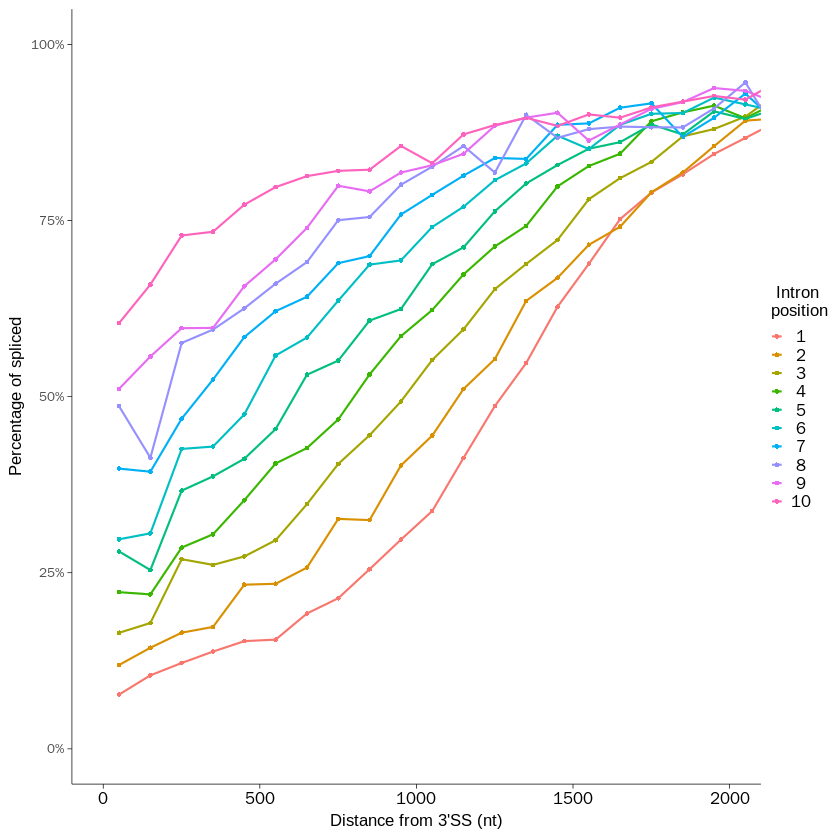

In [308]:
tmp_fileout_pdf <- paste0(plot_dir, "intron_pos.splice_kinetics.pdf")

pdf(tmp_fileout_pdf, 2, 1.6)
    p <- tmp_plot(d, for_pdf=TRUE)
    print(p)
dev.off()

p <- tmp_plot(d, for_pdf=FALSE)
print(p)

# 3. Figure 3

## 3.1 Correction of the ratios of unspliced introns between Illumina RNA-seq and Nanopore

In [347]:
tmp_plot <- function(d){
    p <- ggplot(d, aes(ir_ratio_CB, CB_iratio)) + 
      geom_point(size=0.02, shape=16, alpha=0.5, col=brewer.pal(9, "Set1")[1]) +
      scale_y_continuous(expand=c(0.01,0.05),labels=scales::percent_format(accuracy = 1), limits=c(0,1)) +
      scale_x_continuous(expand=c(0.01,0.05),labels=scales::percent_format(accuracy = 1), limits=c(0,1)) + 
      xlab("Unspliced ratio (Nanopore)") +
      ylab("Unspliced ratio (Illumina)") +
      theme_classic() +
      theme(text=element_text(size=6),
        #legend.position = c(0.2, 0.8), 
        legend.key.size = unit(0.7,"line"),
        #legend.title=element_blank(),
        legend.text = element_text(size=6),
        axis.ticks = element_line(colour = "black", size = 0.2),
        #legend.margin=margin(0,0,0,0),
        #legend.box.margin=margin(-10,0,-10,-10),
        axis.line.y = element_line(color="black", size = 0.2),
        axis.line.x = element_line(color="black", size = 0.2),
        panel.spacing = unit(0.1, "lines"),
        #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
        axis.text.x = element_text(size=6, color="black")
      ) +
      coord_fixed()
    return(p)
}

In [348]:
tmp_d <- inner_join(cb_ir, ngs_cb, by="intron_id") %>% 
        filter(total_read_num_CB>=10, CB_t>=20)

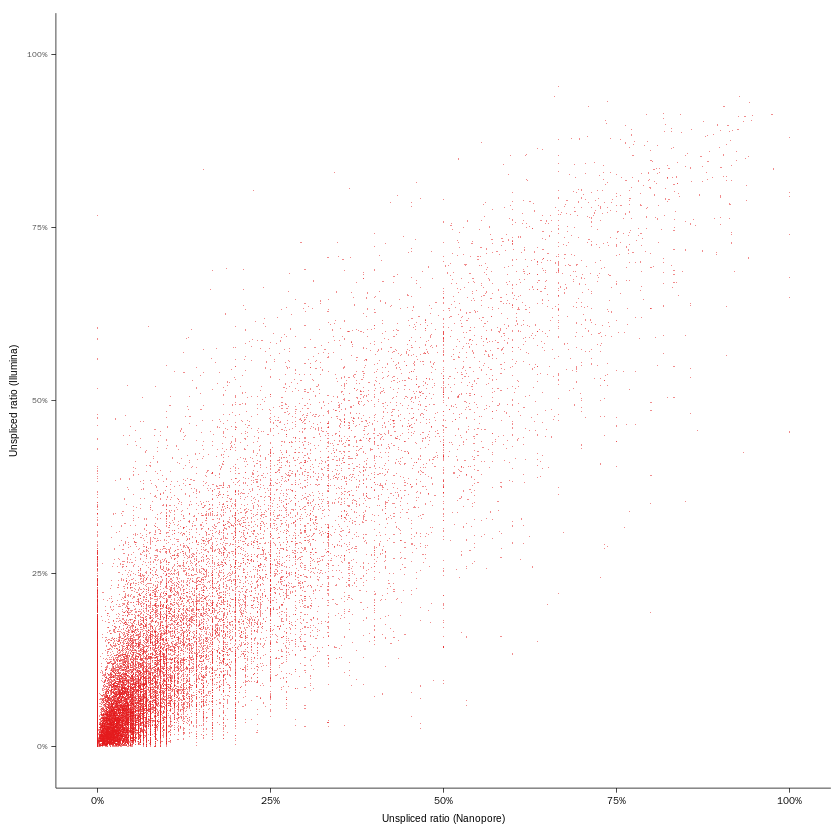

In [349]:
p <- tmp_plot(tmp_d)
print(p)

tmp_fileout_pdf <- paste0(plot_dir, "intron.unspliced_ratio.nanopore.rna_seq.pdf")
pdf(tmp_fileout_pdf, 1.7, 1.7)
print(p)
dev.off()

In [373]:
five_intron_mRNAs <- unique(cb$mRNA[cb$mRNA_intron_num == 5])
five_intron_mRNAs <- five_intron_mRNAs[five_intron_mRNAs %in% select_mRNAs]

In [357]:
tmp_d <- str_split(cb_ir$intron_id, "_", n=2, simplify = T)
cb_ir$mRNA <- tmp_d[,1]
cb_ir$intron_num <- as.numeric(substr(tmp_d[,2], 7, nchar(tmp_d[,2])))

Warning message in stri_split_regex(string, pattern, n = n, simplify = simplify, :
“argument is not an atomic vector; coercing”


In [375]:
d <- cb_ir %>% filter(mRNA %in% five_intron_mRNAs,
                total_read_num_CB>=10) %>%
    select(mRNA, intron_num, iratio=ir_ratio_CB) %>%
    spread(key=intron_num, value=iratio)

In [377]:
d$max_index <- apply(d[2:6], 1, which.max)
d$max <- apply(d[2:6], 1, max)
d <- arrange(d, max_index, -max)

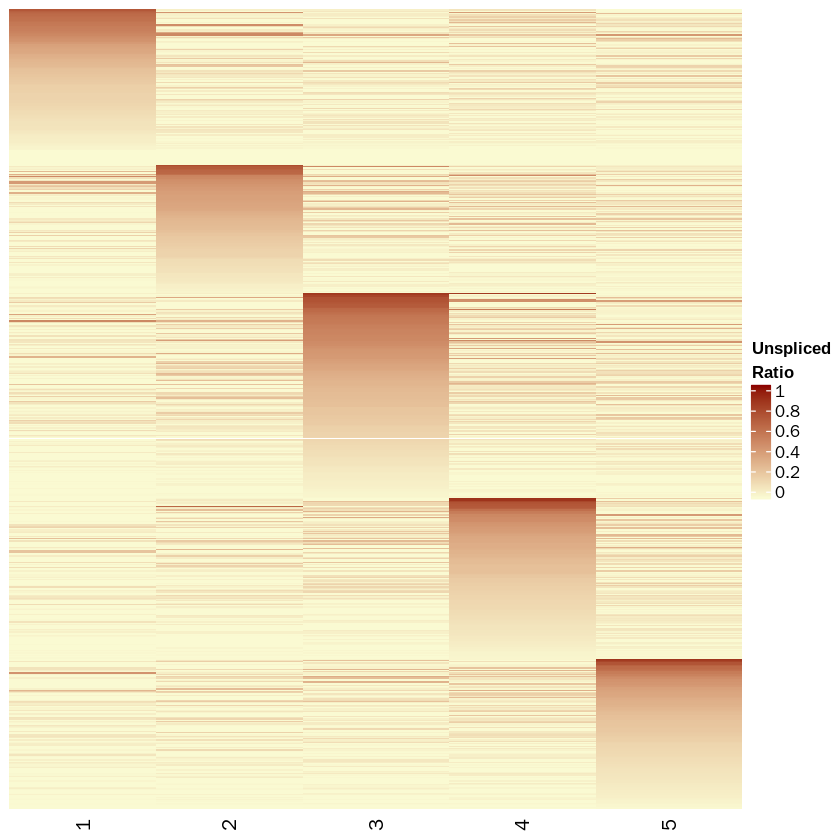

In [378]:
png(tmp_fileout_pdf, width = 4.5, height = 3.2, units = 'in', res = 300)
Heatmap(d[, 2:6], cluster_columns=F, 
        cluster_rows=F,
        col=circlize::colorRamp2(c(0, 1),  c("lightgoldenrodyellow","darkred")),
        #col=circlize::colorRamp2(c(0, 1),  c("snow","steelblue")),
        #col=circlize::colorRamp2(c(0, 1),  c("snow","black")),
        heatmap_legend_param = list(title="Unspliced\nRatio"),
        show_row_names=F)
dev.off()

Heatmap(d[, 2:6], cluster_columns=F, 
        cluster_rows=F,
        col=circlize::colorRamp2(c(0, 1),  c("lightgoldenrodyellow","darkred")),
        #col=circlize::colorRamp2(c(0, 1),  c("snow","steelblue")),
        #col=circlize::colorRamp2(c(0, 1),  c("snow","black")),
        heatmap_legend_param = list(title="Unspliced\nRatio"),
        show_row_names=F)

## 3.2 Global analysis of the spliced ratio versus the transcription distance of introns with different unspliced ratios in chromatin-bound polyadenylated RNA

In [385]:
bin_length = 20

xs11 <- stat_intron_splice(cb1_rel_pos %>% filter(read_core_id  %in% elongating$read_core_id, 
                                                   intron_id %in% pts_introns), 
                           bin_length = bin_length)
xs21 <- stat_intron_splice(cb1_rel_pos %>% filter(read_core_id  %in% elongating$read_core_id, 
                                                   !(intron_id %in% pts_introns)), 
                           bin_length = bin_length)
xs12 <- stat_intron_splice(cb2_rel_pos %>% filter(read_core_id  %in% elongating$read_core_id, 
                                                   intron_id %in% pts_introns), 
                           bin_length = bin_length)
xs22 <- stat_intron_splice(cb2_rel_pos %>% filter(read_core_id  %in% elongating$read_core_id, 
                                                   !(intron_id %in% pts_introns)), 
                           bin_length = bin_length)

xs1 <- inner_join(xs11, xs12, by="pos_bin")
xs1$spliced_ratio = rowMeans(xs1[c("spliced_ratio.x", "spliced_ratio.y")])
xs1$sd = apply(xs1[c("spliced_ratio.x", "spliced_ratio.y")], 1, sd)

xs2 <- inner_join(xs21, xs22, by="pos_bin")
xs2$spliced_ratio = rowMeans(xs2[c("spliced_ratio.x", "spliced_ratio.y")])
xs2$sd = apply(xs2[c("spliced_ratio.x", "spliced_ratio.y")], 1, sd)

xs1$sample <- ">=0.1"
xs2$sample <- "<0.1"
xs <- bind_rows(xs1, xs2)

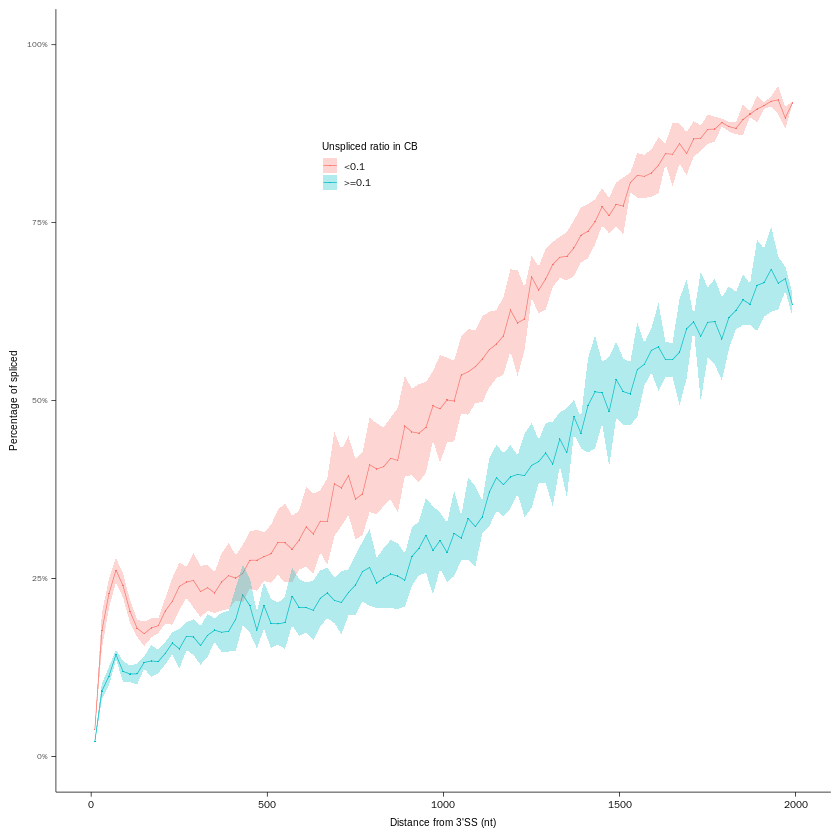

In [386]:
p <- ggplot(xs[xs$pos_bin<2000,], aes(x=pos_bin, y=spliced_ratio, col=sample)) + 
  geom_point(size=0.1, shape = 16) +
  geom_line(size=0.2) +
  geom_ribbon(aes(x=pos_bin, ymin=spliced_ratio-sd, ymax=spliced_ratio+sd,fill=sample), 
              colour = NA,
              alpha=0.3) +
  coord_cartesian(xlim=c(0,2000), ylim=c(0,1)) + 
  scale_y_continuous(labels=scales::percent) +
  xlab("Distance from 3'SS (nt)") + 
  ylab("Percentage of spliced") +
  labs(col="Unspliced ratio in CB", fill="Unspliced ratio in CB") +
  theme_classic() +
  theme(text=element_text(size=6),
        legend.background = element_blank(),
        legend.position = c(0.4, 0.8), 
        legend.key.size = unit(0.7,"line"),
        #legend.title=element_blank(),
        legend.text = element_text(size=6),
        axis.ticks = element_line(colour = "black", size = 0.2),
        #legend.margin=margin(0,0,0,0),
        #legend.box.margin=margin(-10,0,-10,-10),
        axis.line.y = element_line(color="black", size = 0.2),
        axis.line.x = element_line(color="black", size = 0.2),
        panel.spacing = unit(0.1, "lines"),
        #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
        axis.text.x = element_text(size=6, color="black")
  )

tmp_fileout_pdf <- paste0(plot_dir, "p_intron.splice_kinetics.0.1cutoff.biological.pdf")
pdf(tmp_fileout_pdf, 1.7, 1.6)
print(p)
dev.off()

print(p)

## 3.3 The distribution of ratios of unspliced introns of polyadenylated transcripts

png 
  2

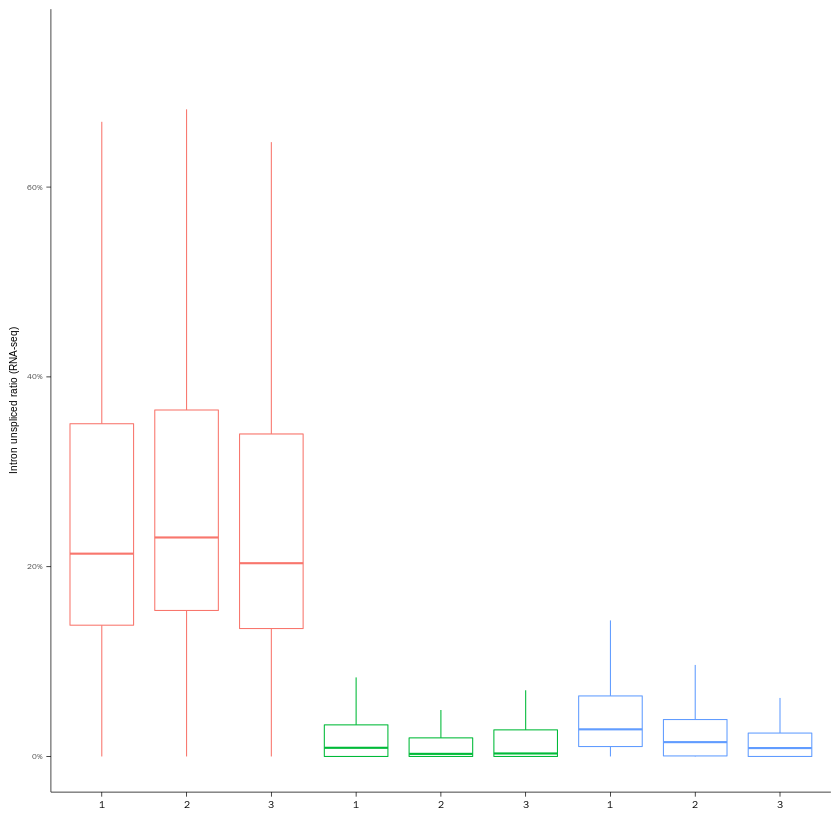

In [387]:
d <- ngs_cb %>% filter(intron_id %in% pts_introns) %>%
            select(intron_id, ends_with("_iratio")) %>%
            gather(ends_with("_iratio"), key=sample, value=iratio)
d$sample <- str_split(d$sample, "_", 2, simplify = TRUE)[,1]

rnaseq_sample_info <- tibble(sample = c("CB1", "CB2", "CB3", 
                                        "NP1", "NP2", "NP3", 
                                        "Cyto1", "Cyto2", "Cyto3"),
                              group = c("CB", "CB", "CB", 
                                         "NP", "NP", "NP", 
                                         "Cyto", "Cyto", "Cyto"),
                              rep = c(1,1,1,2,2,2,3,3,3))

d <- inner_join(d, rnaseq_sample_info, by="sample")

tmp_fileout_pdf <- paste0(plot_dir, "cb.np.cyto.pintron.iratio.pdf")

pdf(tmp_fileout_pdf, 1.8,1.6)
text1 <- tibble(x=c(2,5,8),
                y=-0.18,
                label=c("CB","NP", "Cyto"))
lines <- tibble(x=c(0.6,3.6,6.6), 
                xend=c(3.4, 6.4, 9.4),
                y=-0.15,
                yend=-0.15)
p <- ggplot() +
  geom_boxplot(aes(sample, iratio, color=group), d, outlier.shape=NA, size=0.3) + 
  scale_x_discrete(labels=c(1,2,3,1,2,3,1,2,3),name="") +
  coord_cartesian(clip = 'off', ylim=c(0,0.75)) + 
  geom_text(aes(x,y, label=label), text1, size=6/14*5) +
  geom_segment(aes(x,y, xend=xend, yend=yend), lines, size=0.3) +
  ylab("Intron unspliced ratio (RNA-seq)") +
  scale_y_continuous(labels=scales::percent_format(accuracy = 1)) +
  theme_classic() +
  theme(text=element_text(size=6),
        legend.position = "none", #c(0.8, 0.7), 
        legend.key.size = unit(0.7,"line"),
        legend.title=element_blank(),
        legend.text = element_text(size=6),
        axis.ticks = element_line(colour = "black", size = 0.2),
        #legend.margin=margin(0,0,0,0),
        #legend.box.margin=margin(-10,0,-10,-10),
        axis.line.y = element_line(color="black", size = 0.2),
        axis.line.x = element_line(color="black", size = 0.2),
        panel.spacing = unit(0.1, "lines"),
        #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
        axis.text.x = element_text(size=6, color="black")
  ) 
print(p)
dev.off()

print(p)

## 3.4 The difference in transcript abundance between chromatin, nucleoplasm and cytoplasm

In [419]:
tmp_plot_func <- function(d, xcolumn, ycolumn, colcolumn, xlab, ylab){
    xlab <- paste0("log10(FPKM+1) ", xcolumn)
    ylab <- paste0("log10(FPKM+1) ", ycolumn)
    p <- ggplot(d, aes(log10(!!as.name(xcolumn)+1), 
                       log10(!!as.name(ycolumn)+1), 
                       col=!!as.name(colcolumn))) + 
          geom_point(size=0.01, shape = 16)  + 
          labs(col="Incompletely\nsplcied ratio") + 
          xlab(xlab) + 
          ylab(ylab) +
          scale_color_gradient2(midpoint=0.5, low="blue", mid="white",
                             high="red", space ="Lab" ) +
          coord_fixed() + scale_x_continuous(limits=c(0,3.5)) +  scale_y_continuous(limits=c(0,3.5)) +
          theme_classic() +
          theme(text=element_text(size=6),
                #legend.position = c(0.2, 0.8), 
                legend.key.size = unit(0.7,"line"),
                #legend.title=element_blank(),
                legend.text = element_text(size=6),
                axis.ticks = element_line(colour = "black", size = 0.2),
                #legend.margin=margin(0,0,0,0),
                #legend.box.margin=margin(-10,0,-10,-10),
                axis.line.y = element_line(color="black", size = 0.2),
                axis.line.x = element_line(color="black", size = 0.2),
                panel.spacing = unit(0.1, "lines"),
                #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
                axis.text.x = element_text(size=6, color="black")
          ) 
    return(p)
}

In [424]:
cb_incompletely$gene <- str_split(cb_incompletely$mRNA, "\\.", n=2, simplify=TRUE)[,1]
d <- inner_join(cb_incompletely, ngs_fpkm, by="gene") %>% filter(mRNA %in% select_mRNAs)
d <- filter(d, total_read_num_CB>=10)

png 
  2

png 
  2

png 
  2

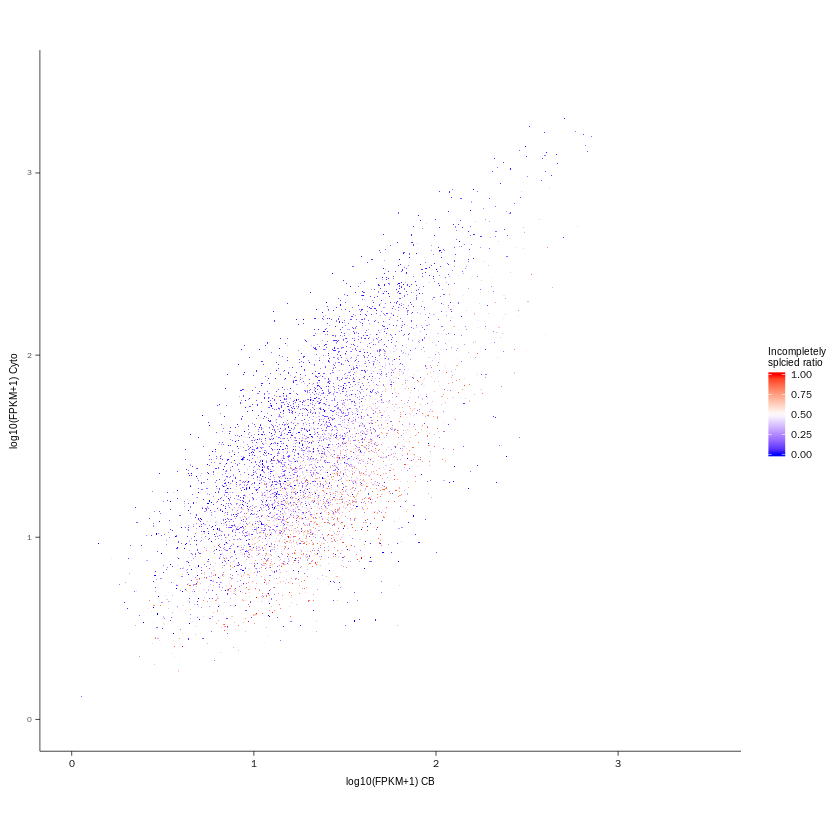

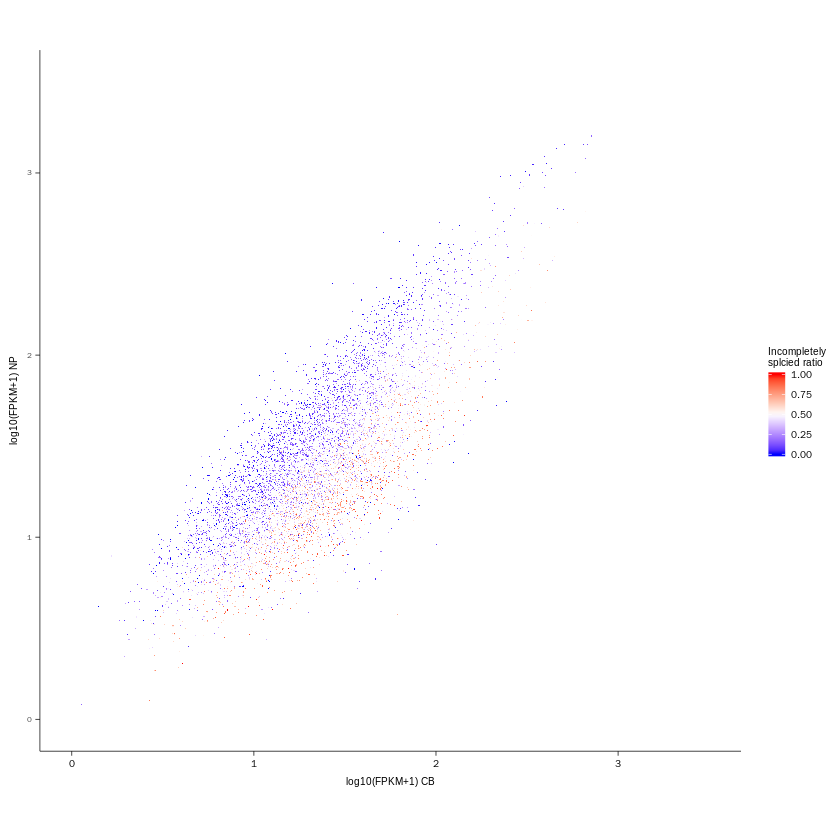

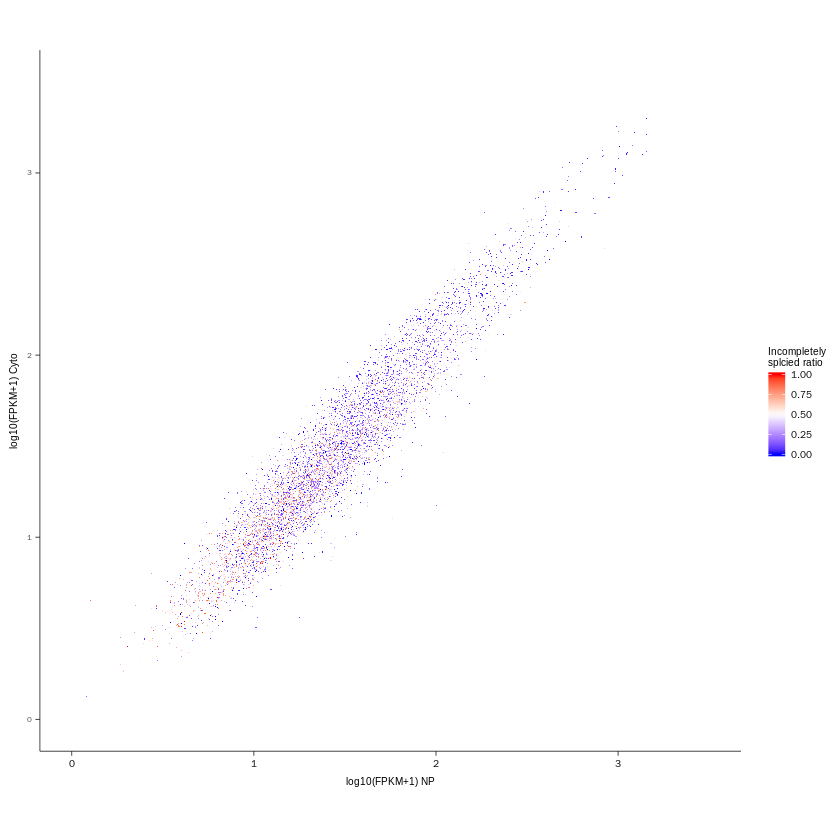

In [425]:
tmp_fileout_pdf_cbcyto <- paste0(plot_dir, "incomplete.fpkm.cb.cyto.pdf")
tmp_fileout_pdf_cbnp <- paste0(plot_dir, "incomplete.fpkm.cb.np.pdf")
tmp_fileout_pdf_npcyto <- paste0(plot_dir, "incomplete.fpkm.np.cyto.pdf")

pdf(tmp_fileout_pdf_cbcyto, 2.5, 1.6)
p1 <- tmp_plot_func(d, "CB", "Cyto", "ir_ratio_CB", "Chromatin", "Cytoplasm")
print(p1)
dev.off()


pdf(tmp_fileout_pdf_cbnp, 2.5, 1.6)
p2 <- tmp_plot_func(d, "CB", "NP", "ir_ratio_CB", "Chromatin", "Nucleoplasm")
print(p2)
dev.off()

pdf(tmp_fileout_pdf_npcyto, 2.5, 1.6)
p3 <- tmp_plot_func(d, "NP", "Cyto", "ir_ratio_CB", "Nucleoplasm", "Cytoplasm")
print(p3)
dev.off()

print(p1)
print(p2)
print(p3)

# 4. Figure 4

## 4.1 The pts intron ratio of IRs in mutants or treatments

In [433]:
tmp_plot_func <- function(d, expected_ratio=0.283, add_label=FALSE, col_label=FALSE, 
                         xlimmax=3500, breaks=c(50, 1000, 2000, 3000)){
    p <- ggplot() + 
      #geom_vline(xintercept=500, linetype="dashed", color="grey", size=0.4) +
      geom_hline(yintercept=expected_ratio,linetype="dashed", color = "black", size=0.5)
      #geom_text(aes(x=3000,y=0.05,label="Expected ratio: 28%"), tibble(), col="black", size=6*5/14, family="serif") 
    if (col_label) {
        p <- p + geom_point(aes(IR_up, IR_up_pintron_ratio, col=col_label), d, size=0.6, shape = 16) +
                scale_color_manual(values=c(brewer.pal(9, "Set1")[c(1,2)], "grey")) +
                labs(col="") 
    } else {
        p <- p + geom_point(aes(IR_up, IR_up_pintron_ratio), col="red", d, size=0.6, shape = 16)
    }
    
    p<- p +
      #scale_x_log10() + #scale_x_log10(breaks=c(100,1000,3000))+ 
      scale_y_continuous(labels=scales::percent_format(accuracy = 1), limits=c(0,1),
                     breaks=c(0,0.2,0.4,0.6,0.8,1)) +
      scale_x_continuous(expand=c(0,0),limits=c(50,xlimmax),
                     breaks=breaks) +
      ylab("Ratio of pts-introns") +
      xlab("Number of introns with increased IR") +
      theme_classic() +
      theme(text=element_text(size=6),
            #legend.position = c(0.2, 0.8), 
            legend.key.size = unit(0.7,"line"),
            #legend.title=element_blank(),
            legend.text = element_text(size=6),
            axis.ticks = element_line(colour = "black", size = 0.2),
            #legend.margin=margin(0,0,0,0),
            #legend.box.margin=margin(-10,0,-10,-10),
            axis.line.y = element_line(color="black", size = 0.2),
            axis.line.x = element_line(color="black", size = 0.2),
            panel.spacing = unit(0.1, "lines"),
            #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
            axis.text.x = element_text(size=6, color="black")
      )
    if (add_label){
        p <- p + geom_text(aes(x=IR_up, y=IR_up_pintron_ratio, label=label),
                           data =d,  col="black", size=6*5/14, family="serif") 
    }
    return(p)
}

png 
  2

png 
  2

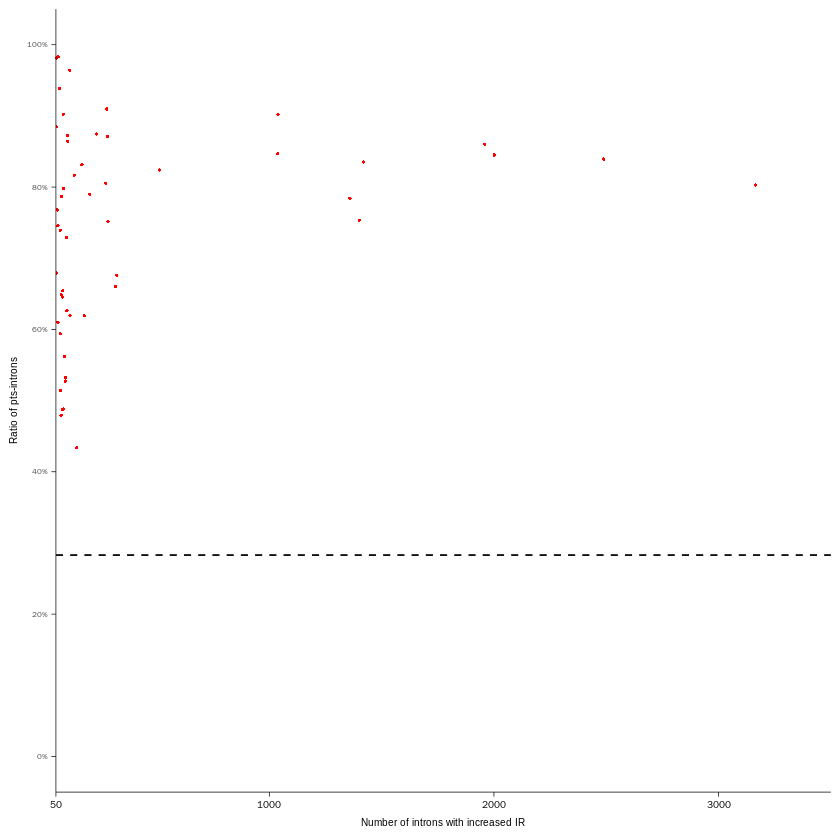

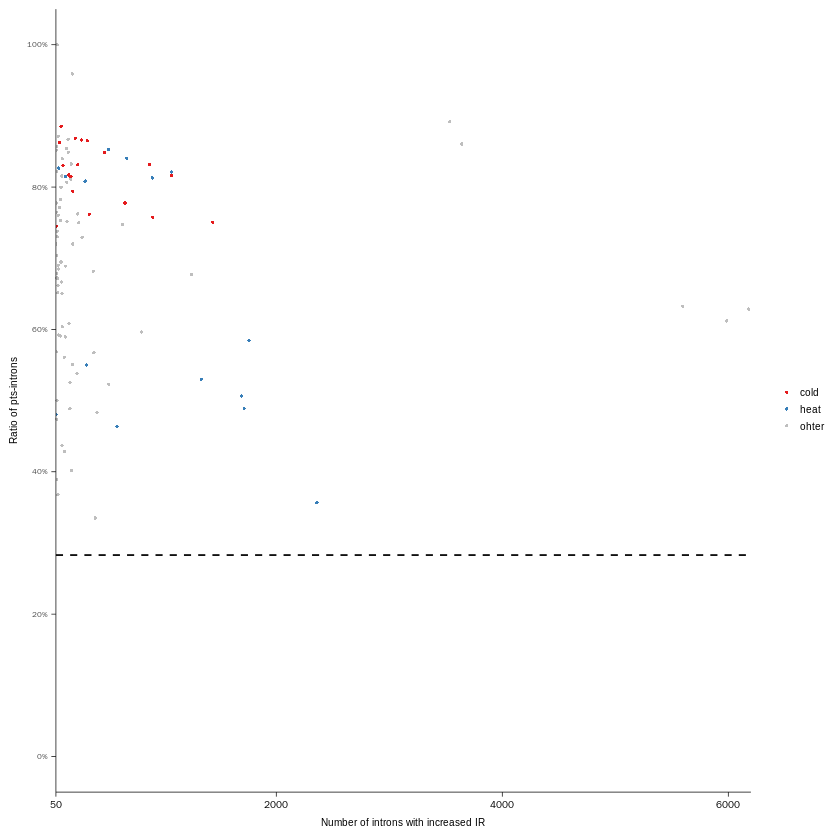

In [434]:
tmp_fileout_pdf_mutant <- paste0(plot_dir, "public_ir.mutant.pdf")
tmp_fileout_pdf_treatment <- paste0(plot_dir, "public_ir.treatment.pdf")

pdf(tmp_fileout_pdf_mutant, 2.5, 1.8)
p1 <- tmp_plot_func(filter(ir_mutant, IR_up>=50))
print(p1)
dev.off()

#去除flg22
tmp_d <- ir_treatment %>% mutate(col_label = fct_collapse(col_label,
                  ohter= c("other", "flg22"))) %>% 
                  filter(IR_up>=50)

pdf(tmp_fileout_pdf_treatment, 2.5, 1.8)
p2 <- tmp_plot_func(tmp_d, col_label=TRUE, xlimmax=6200, breaks=c(50, 2000, 4000, 6000))
print(p2)
dev.off()

print(p1)
print(p2)

## 4.2 The Δunspliced ratios (mutant − WT) distribution of introns with different unspliced ratios in chromatin-bound polyadenylated RNA

In [439]:
tmp_read_ir <- function(filein, label_name=""){
  suppressMessages(
  {
      d <- read_tsv(filein)
  })
  d <- d[d$intron_id %in% ngs_cb$intron_id, ]
  if (label_name!=""){
    colnames(d)[2:ncol(d)] <- paste0(label_name, "_", c("at", "bt", "airatio", "biratio", "padj", "type", "bmaratio", "abratio"))
  }
  return(d)
}

In [443]:
label_names <- c("prmt5", "skip", "upf1upf3")
d <- tmp_read_ir(file_skip_ir, "skip")
d <- inner_join(d, tmp_read_ir(file_prmt5_ir, "prmt5"), by="intron_id")
d <- inner_join(d, tmp_read_ir(file_upf1upf3_ir, "upf1upf3"), by="intron_id")
d <- inner_join(d, ngs_cb, by="intron_id")
d$type <- cut(d$CB_iratio, c(0,0.05,0.1,0.2,1), labels=c("0-0.05", "0.05-0.1","0.1-0.2","0.2-1"),include.lowest = T)
d <- do.call(bind_rows, lapply(label_names, function(label) {
                f1=c(d[[paste0(label, "_at")]]>=10 & (d[[paste0(label, "_bt")]]>=10));
                tibble(ratio=d[[paste0(label, "_biratio")]][f1]-d[[paste0(label, "_airatio")]][f1], 
                       sample=label, type=d$type[f1])}))
d$sample <- factor(d$sample, 
                   levels=label_names)

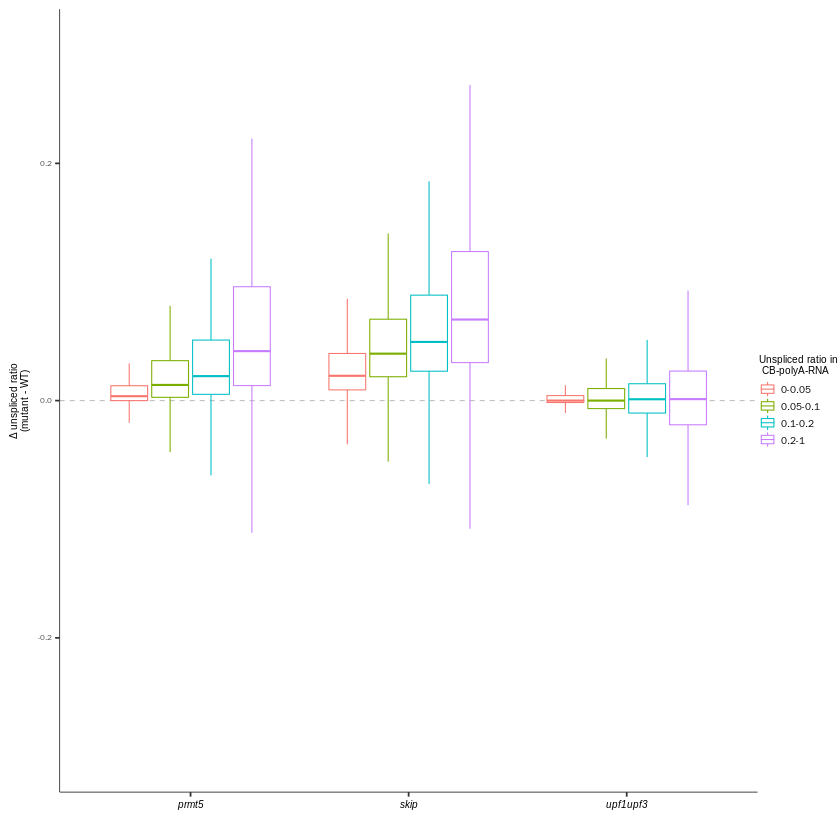

In [445]:
p <- ggplot(d, aes(sample, ratio, col=type)) + 
  labs(fill="pintron") +
  ylab("\U0394 unspliced ratio\n(mutant - WT)") +
  xlab("") + 
  labs(col="Unspliced ratio in\n CB-polyA-RNA") +
  scale_fill_manual(values = brewer.pal(9, "Set1")) +
  #scale_fill_manual(values = c("#00AFBB", "#E7B800", "#FC4E07")) +
  geom_hline(yintercept = 0, col="grey", size=0.3, linetype=2) +
  geom_boxplot(outlier.shape=NA,  size=0.3)  + 
  coord_cartesian(ylim = c(-0.3,0.3)) + 
  theme_classic() +
  theme(text=element_text(size=6),
        #legend.position = c(0.2, 0.8), 
        legend.key.size = unit(0.7,"line"),
        #legend.title=element_blank(),
        legend.text = element_text(size=6),
        legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,0,-10,-10),
        axis.line.y = element_line(color="black", size = 0.2),
        axis.line.x = element_line(color="black", size = 0.2),
        panel.spacing = unit(0.1, "lines"),
        #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
        axis.text.x = element_text(size=6, color="black", face="italic")
  ) 

print(p)

## 4.3 The Δunspliced ratios (treatment − control/mock) distribution of introns with different unspliced ratios in chromatin-bound polyadenylated RNA.

In [446]:
label_names <- c("cold", "heat1", "heat2")
d <- tmp_read_ir(file_cold_ir, "cold")
d <- inner_join(d, tmp_read_ir(file_heat1_ir, "heat1"), by="intron_id")
d <- inner_join(d, tmp_read_ir(file_heat2_ir, "heat2"), by="intron_id")
d <- inner_join(d, ngs_cb, by="intron_id")

d$type <- cut(d$CB_iratio, c(0,0.05,0.1,0.2,1), labels=c("0-0.05", "0.05-0.1","0.1-0.2","0.2-1"),include.lowest = T)

d <- do.call(bind_rows, lapply(label_names, function(label) {
                f1=c(d[[paste0(label, "_at")]]>=10 & (d[[paste0(label, "_bt")]]>=10));
                tibble(ratio=d[[paste0(label, "_biratio")]][f1]-d[[paste0(label, "_airatio")]][f1], 
                       sample=label, type=d$type[f1])}))

d$sample <- factor(d$sample, 
                   levels=label_names)


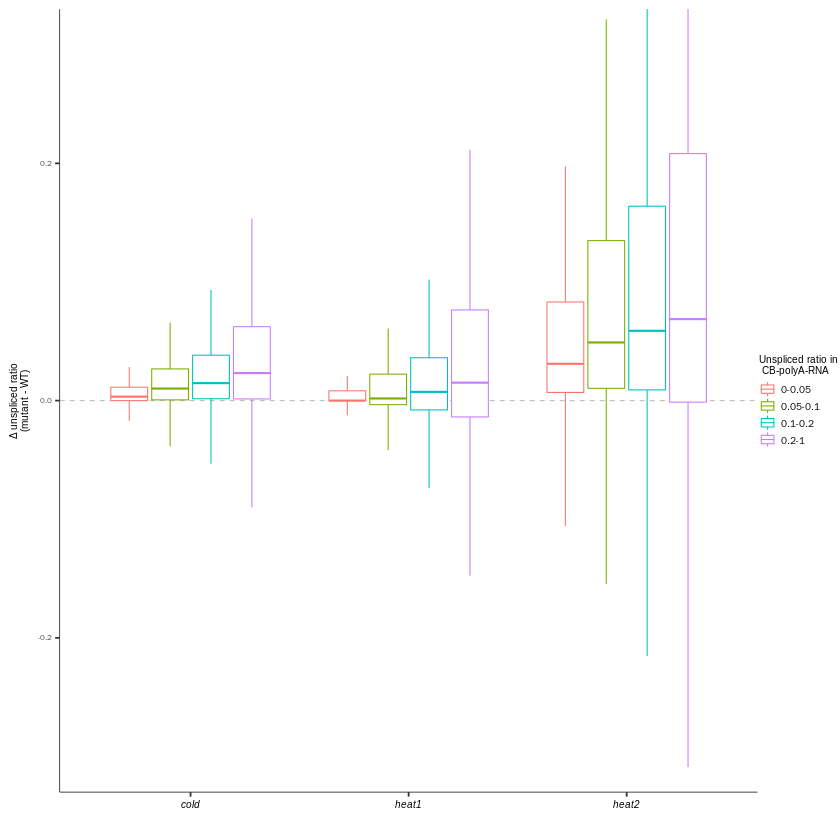

In [448]:
p <- ggplot(d, aes(sample, ratio, col=type)) + 
  labs(fill="pintron") +
  ylab("\U0394 unspliced ratio\n(mutant - WT)") +
  xlab("") + 
  labs(col="Unspliced ratio in\n CB-polyA-RNA") +
  scale_fill_manual(values = brewer.pal(9, "Set1")) +
  #scale_fill_manual(values = c("#00AFBB", "#E7B800", "#FC4E07")) +
  geom_hline(yintercept = 0, col="grey", size=0.3, linetype=2) +
  geom_boxplot(outlier.shape=NA,  size=0.3)  + 
  coord_cartesian(ylim = c(-0.3,0.3)) + 
  theme_classic() +
  theme(text=element_text(size=6),
        #legend.position = c(0.2, 0.8), 
        legend.key.size = unit(0.7,"line"),
        #legend.title=element_blank(),
        legend.text = element_text(size=6),
        legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,0,-10,-10),
        axis.line.y = element_line(color="black", size = 0.2),
        axis.line.x = element_line(color="black", size = 0.2),
        panel.spacing = unit(0.1, "lines"),
        #axis.text.x = element_text(angle = 315, vjust = 0.5, hjust = 0)
        axis.text.x = element_text(size=6, color="black", face="italic")
  ) 


print(p)